In [ ]:
import sys
sys.path.append('..')
import jax
from jax import vmap
import numpy as np
from src.util import *
from src.plot import *
import matplotlib.pyplot as plt

if True:
    for j in range(100):
        clist = []
        M = 1000
        for i in range(M):
            print(f"{i+1}/{M}", end='\r')
            clist.append(loop_erased_rw())
            
        data = jnp.array(clist)
        jnp.save(f'data_{j}.npy', data)

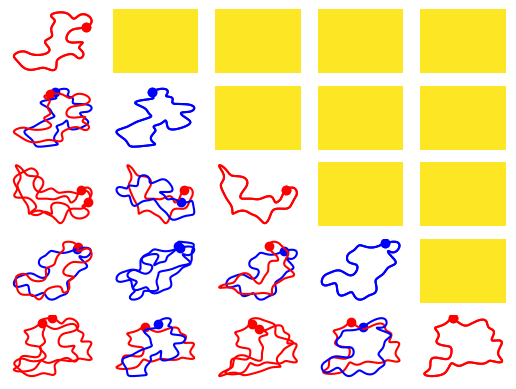

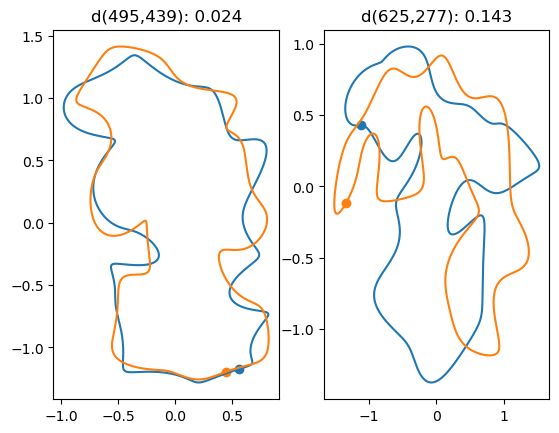

In [ ]:
Nref = 100
clist = jnp.load('data.npy')

def plot_corr_table(width, clist, Nref=40):
    for i in range(width):
        for j in range(i+1):
            col1 = "red" if i % 2 == 0 else "blue"
            col2 = "red" if j % 2 == 0 else "blue"
            c1 = clist[i]
            c2 = clist[j]
            c21 = align_fourier(c2, c1, Nref=Nref)        
            dist = error(c1, c21)
            
            plt.subplot(width, width, i*width+j+1)
            plot_fourier_curve(c1, color=col1)
            plot_fourier_curve(c21, color=col2)
            plt.axis("off")
            
            ax = plt.subplot(width, width, j*width+i+1)
            # Color background according to distance
            ax.set_facecolor(plt.cm.viridis(dist/0.01))
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

def get_dist_table(clist, Nref=40):
    distance_wrap = lambda x1, x2: distance(x1, x2, Nref=Nref)
    return vmap(vmap(distance_wrap, (0, None)), (None, 0))(clist, clist)

def get_table_min(table):
    table_mask = jnp.where(jnp.identity(table.shape[0]), jnp.nan, table)
    idx_min = jnp.nanargmin(table_mask)
    (row_min, col_min) = jnp.unravel_index(idx_min, table.shape)
    return row_min, col_min

def get_table_max(table):
    table_mask = jnp.where(jnp.identity(table.shape[0]), jnp.nan, table)
    idx_max = jnp.nanargmax(table_mask)
    (row_max, col_max) = jnp.unravel_index(idx_max, table.shape)
    return row_max, col_max

plot_corr_table(5, clist, Nref=Nref)
    
table = get_dist_table(clist, Nref=Nref)
row_min, col_min = get_table_min(table)
row_max, col_max = get_table_max(table)


plt.figure()
for itern, (i, j) in enumerate(zip([row_min, row_max], [col_min, col_max])):
    c1 = clist[i]
    c2 = clist[j]
    c21 = align_fourier(c2, c1, Nref=Nref)        
    dist = error(c1, c21)
    
    plt.subplot(1, 2, itern+1)
    plot_fourier_curve(c1)
    plot_fourier_curve(c21)
    plt.title(f"d({i},{j}): {dist:.3f}")
    

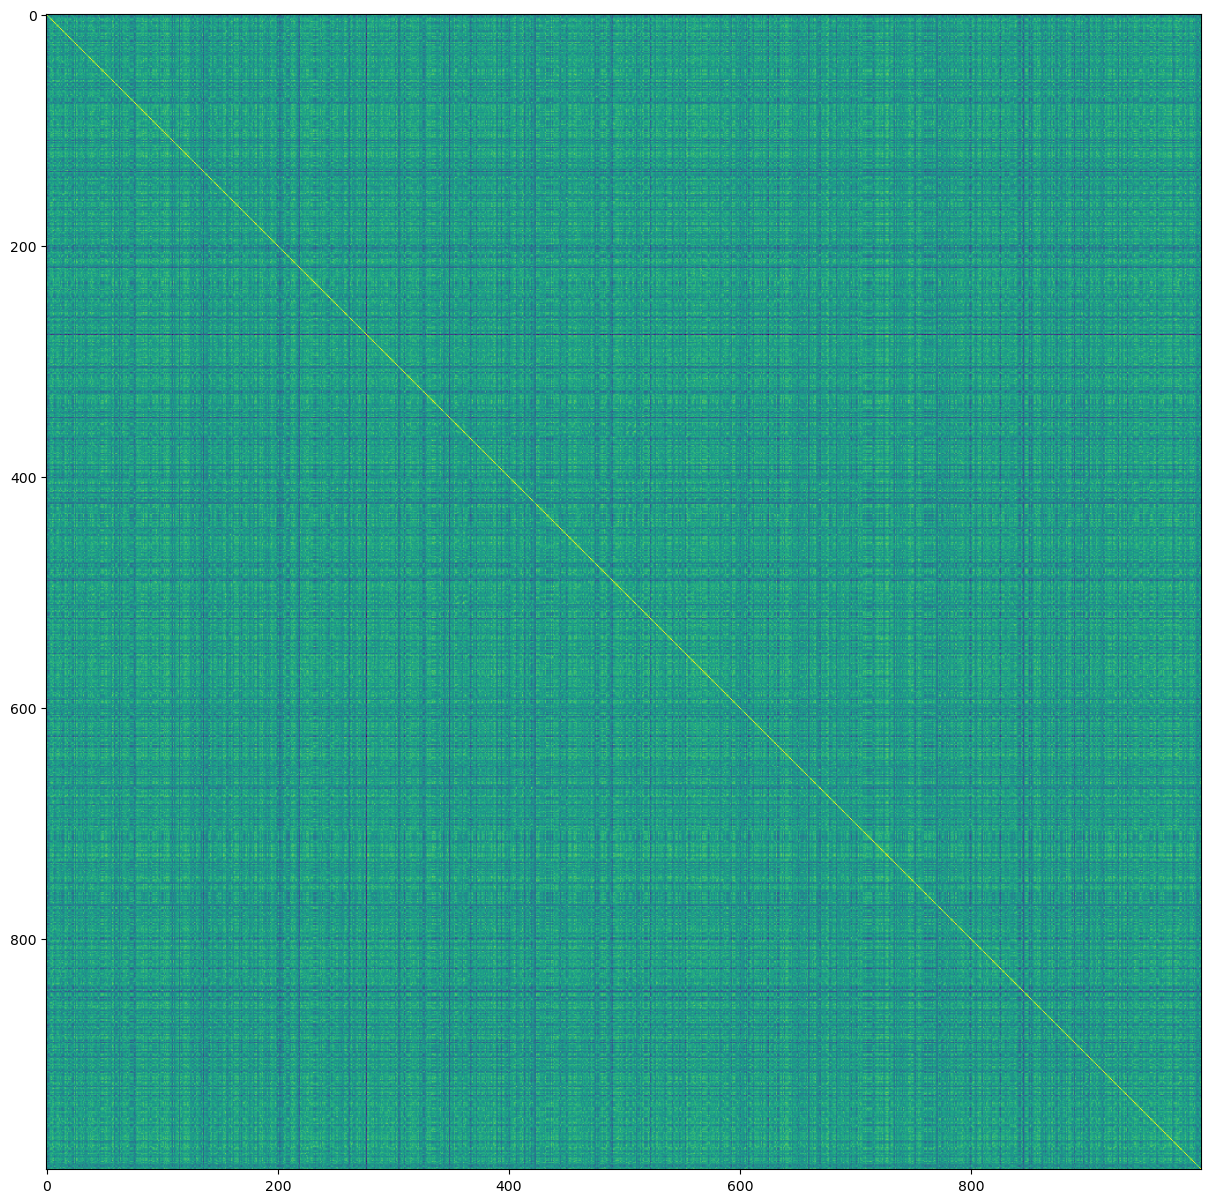

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(np.exp(-table))